In [1]:
import cftime
import datetime
import glob
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy.optimize import curve_fit

%matplotlib widget

In [2]:
def window_mean(arr, window_size):
    """
    Compute the window mean (moving average) of an array, keeping the output the same length as the input array and handling NaN values.
    
    Parameters:
    arr (list or np.ndarray): Input array.
    window_size (int): The size of the window to compute the mean.
    
    Returns:
    np.ndarray: Array of window means, padded to the same length as the input array.
    """
    # Convert the input array to a numpy array if it isn't one already
    arr = np.asarray(arr, dtype=float)
    
    # Check if the window size is greater than the array length
    if window_size > len(arr):
        raise ValueError("Window size should be less than or equal to the length of the array.")
    
    # Use pandas rolling function to calculate the window mean, handling NaN values
    result = pd.Series(arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
    
    return result

In [3]:
def bathy_along_track(bathy_file:str, xFRF:np.ndarray, yFRF:np.ndarray,
                      single_trajectory=False):
    """
    Linearly interpolates the bathymetry along the track of
    the microSWIFT.

    Parameters
    ----------
    bathy_file : str
        url or path to bathy bathymetry file
    xFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    yFRF : np.ndarray
        1D or 2D array of microSWIFT xFRF locations
    single_trajectory : boolean
        True or False if plotting a single trajectory

    Returns
    -------
    bathy_along_track : np.ndarray
        1D or 2D array of bottom elevation at each location along the track

    """
    if single_trajectory is True:
        xFRF = xFRF.reshape(1,xFRF.size)
        yFRF = yFRF.reshape(1,yFRF.size)
    else:
        pass
    
    # Create bathymetry interpolating function from 2D grid
    bathy_dataset = nc.Dataset(bathy_file)
    x = bathy_dataset['xFRF'][:]
    y = bathy_dataset['yFRF'][:]
    z = bathy_dataset['elevation'][0,:,:]

    # Expand the bathymetry along shore 
    x_cgrid, y_cgrid = np.meshgrid(np.linspace(np.min(x), np.max(x), int((np.max(x)- np.min(x)))),
                                np.linspace(np.min(y), np.max(y), int((np.max(y)- np.min(y)))))

    z_bathy_regridded = interpolate.interpn((x, y), np.transpose(z), (x_cgrid, y_cgrid), method='linear', fill_value=0)
    x_bathy_expanded = np.linspace(50, 950, 900)
    y_bathy_expanded = np.linspace(-1500, 1500, 3000)
    x_cgrid_expand, y_cgrid_expand = np.meshgrid(x_bathy_expanded,
                                                y_bathy_expanded)
    z_bathy_expanded = np.zeros(x_cgrid_expand.shape)
    z_bathy_expanded[1400:2600, :] = z_bathy_regridded
    for n in range(1400):
        z_bathy_expanded[n,:] = z_bathy_expanded[1400,:]

    for n in range(y_bathy_expanded.size - 2600):
        z_bathy_expanded[n+2600,:] = z_bathy_expanded[2599,:]
   
    bathy_f = interpolate.RegularGridInterpolator((x_bathy_expanded, y_bathy_expanded), np.transpose(z_bathy_expanded), 
                                                  method='linear', bounds_error=False)

    bathy_along_track = np.empty(xFRF.shape)
    for trajectory in range(xFRF.shape[0]):
        for n in np.arange(xFRF.shape[1]):
            point = np.array([xFRF[trajectory, n],
                              yFRF[trajectory, n]])
            bathy_along_track[trajectory, n] = np.squeeze(bathy_f(point).item())

    return np.array(bathy_along_track)

In [13]:
# Open the mission file 
mission_nc = '../data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc, mode='r')
trajectory_num = 5

# Extract the x and y locations of each buoy in the FRF coordinate system
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])

# Get the time values of the mission
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
delta_t = (time[1]-time[0]).total_seconds()

# Define the window size
window_size = 36

# Filter x
x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
x_filtered = window_mean(x, window_size)

# Filter y 
y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)
y_filtered = window_mean(y, window_size)

# Compute the instantaneous velocity from the filtered signal
instantaneous_x_vel = np.gradient(x_filtered, delta_t)
instantaneous_y_vel = np.gradient(y_filtered, delta_t)

# Compute distance along the track 
x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)

# Filter the cross shore time series with window mean
x_filtered = window_mean(x, window_size)
y_filtered = window_mean(y, window_size)

# Compute Cross Shore Velocity from Cross Shore Position
instantaneous_x_vel = np.gradient(x_filtered, delta_t)
instantaneous_y_vel = np.gradient(y_filtered, delta_t)

# No filter on velocity
instantaneous_x_vel_nofilter = np.gradient(x, delta_t)
instantaneous_y_vel_nofilter = np.gradient(y, delta_t)
instantaneous_total_vel_nofilter = np.sqrt(instantaneous_x_vel_nofilter**2 + instantaneous_y_vel_nofilter**2)

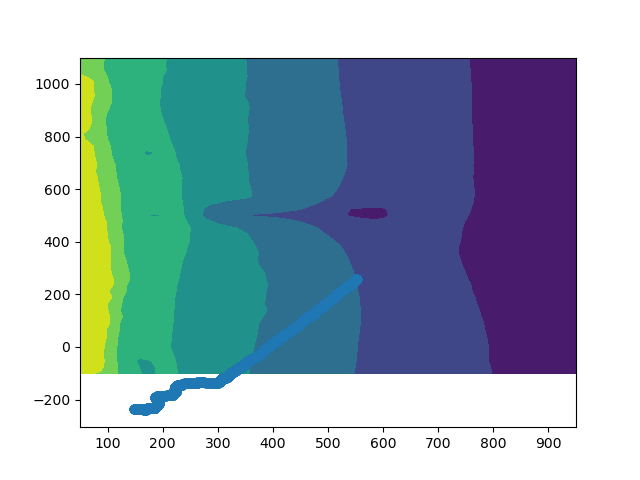

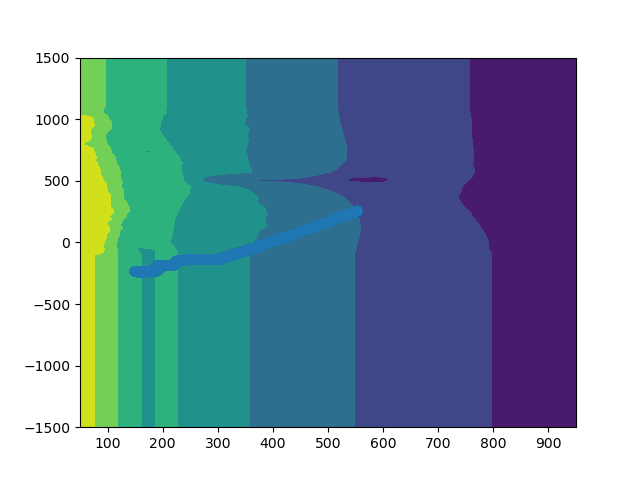

In [5]:
bathy_dataset = nc.Dataset('../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
x_bathy = bathy_dataset['xFRF'][:]
y_bathy = bathy_dataset['yFRF'][:]
z_bathy = bathy_dataset['elevation'][0,:,:]

# Expand Bathymetry 
x_cgrid, y_cgrid = np.meshgrid(np.linspace(np.min(x_bathy), np.max(x_bathy), int((np.max(x_bathy)- np.min(x_bathy)))),
                               np.linspace(np.min(y_bathy), np.max(y_bathy), int((np.max(y_bathy)- np.min(y_bathy)))))

z_bathy_regridded = interpolate.interpn((x_bathy, y_bathy), np.transpose(z_bathy), (x_cgrid, y_cgrid), method='linear', fill_value=0)
x_bathy_expanded = np.linspace(50, 950, 900)
y_bathy_expanded = np.linspace(-1500, 1500, 3000)
x_cgrid_expand, y_cgrid_expand = np.meshgrid(x_bathy_expanded,
                                             y_bathy_expanded)
z_bathy_expanded = np.zeros(x_cgrid_expand.shape)
z_bathy_expanded[1400:2600, :] = z_bathy_regridded
for n in range(1400):
    z_bathy_expanded[n,:] = z_bathy_expanded[1400,:]

for n in range(y_bathy_expanded.size - 2600):
    z_bathy_expanded[n+2600,:] = z_bathy_expanded[2599,:]

fig, ax = plt.subplots()
ax.contourf(x_bathy, y_bathy, z_bathy)
ax.scatter(x_filtered, y_filtered)

fig, ax = plt.subplots()
ax.contourf(x_bathy_expanded, y_bathy_expanded, z_bathy_expanded)
ax.scatter(x_filtered, y_filtered)


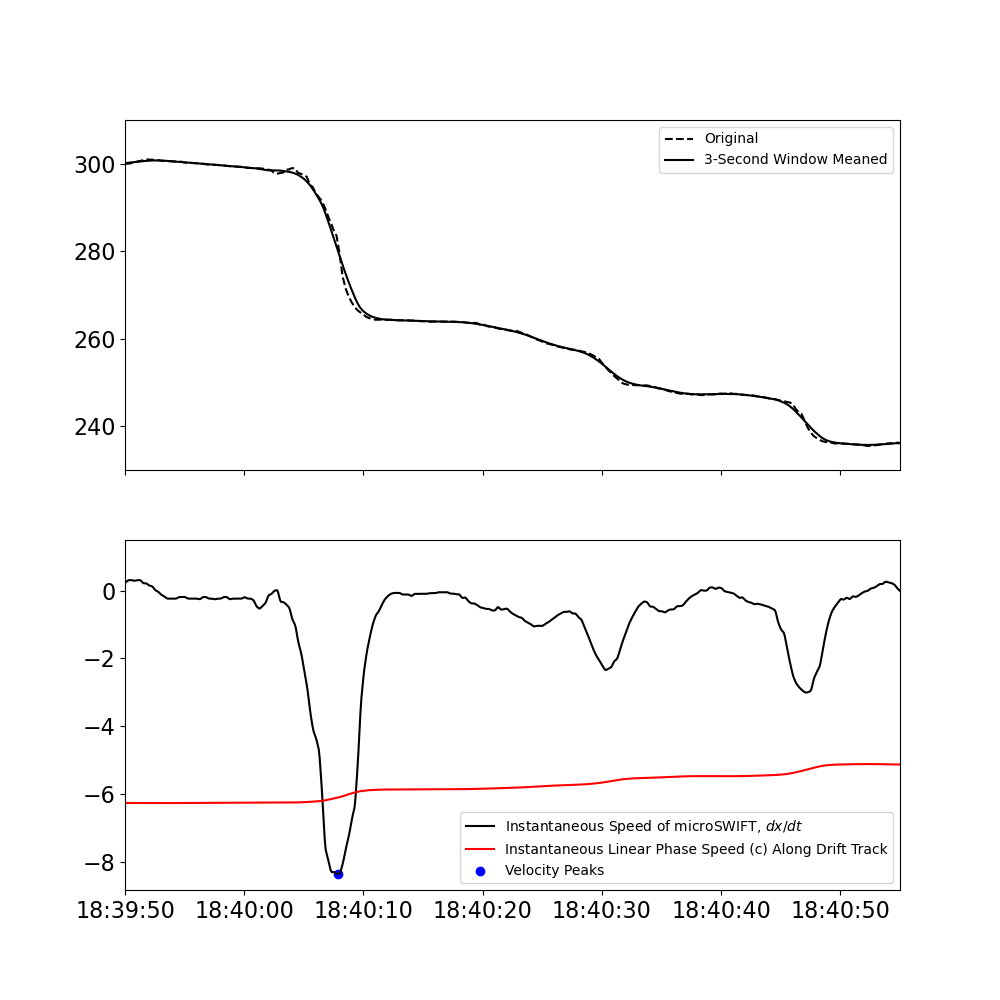

In [12]:


# Compute the Bathy along the buoy track
mission_df = pd.read_csv('../data/mission_df.csv').sort_values(by=['mission number'])
mission_num = 19
water_level = mission_df[mission_df['mission number'] == mission_num]['water level [m]'].values[0]
trajectory_bathy = bathy_along_track(bathy_file='../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                    xFRF=x_filtered, 
                                                    yFRF=y_filtered,
                                                    single_trajectory=True)[0]
trajectory_depth = trajectory_bathy + water_level

# Compute Linear Phase Speed at each point in track
phase_speed_along_track = np.sqrt(np.abs(trajectory_depth * 9.8))

# Find the Peaks in the velocity
distance_between_peaks = int(3*(1/delta_t)) # 3 seconds between points
# vel_threshold = 0.5 * phase_speed_along_track
vel_threshold = 1 * phase_speed_along_track
peak_vel_indices = signal.find_peaks(-instantaneous_x_vel, height=vel_threshold, distance=distance_between_peaks)[0]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10), sharex=True)
ax1.plot(time, x, color='k', linestyle='dashed', label='Original')
ax1.plot(time, x_filtered, color='k', label='3-Second Window Meaned')
# ax1.set_xlabel('Time [UTC]')
# ax1.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 50), datetime.datetime(2021, 10, 8, 18, 40, 55))
ax1.set_ylim(230, 310)
ax1.legend()
ax1.tick_params(axis='both', labelsize=16)

# Instantaneous Velocity
ax2.plot(time, instantaneous_x_vel, color='k', label='Instantaneous Speed of microSWIFT, $dx/dt$')
ax2.plot(time, -1 * phase_speed_along_track, color='r', label='Instantaneous Linear Phase Speed (c) Along Drift Track')
# ax2.plot(time, -1 * 0.5*phase_speed_along_track, color='b', label='Velocity Peak Threshold, $u_{th} = \psi c$')
# ax2.plot(time, -1 * phase_speed_along_track, color='b', label='Velocity Peak Threshold, $u_{th} = \psi c$')
ax2.scatter(time[peak_vel_indices], instantaneous_x_vel[peak_vel_indices], color='b', label='Velocity Peaks')
# ax2.set_xlabel('Time [UTC]')
# ax2.set_ylabel('Cross Shore Speed [m/s]')
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 50), datetime.datetime(2021, 10, 8, 18, 40, 55))
ax2.legend()
ax2.tick_params(axis='both', labelsize=16)



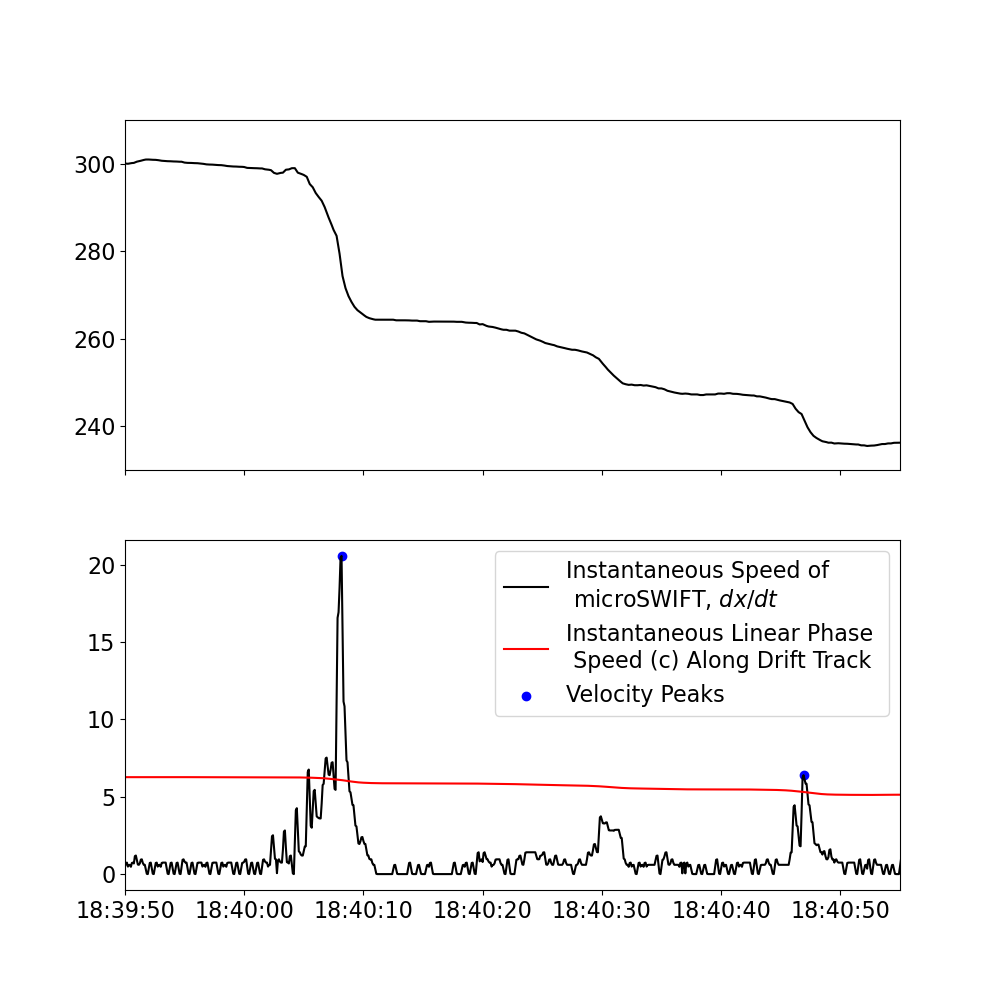

In [52]:
# Compute the Bathy along the buoy track
mission_df = pd.read_csv('../data/mission_df.csv').sort_values(by=['mission number'])
mission_num = 19
water_level = mission_df[mission_df['mission number'] == mission_num]['water level [m]'].values[0]
trajectory_bathy = bathy_along_track(bathy_file='../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc', 
                                                    xFRF=x_filtered, 
                                                    yFRF=y_filtered,
                                                    single_trajectory=True)[0]
trajectory_depth = trajectory_bathy + water_level

# Compute Linear Phase Speed at each point in track
phase_speed_along_track = np.sqrt(np.abs(trajectory_depth * 9.8))

# Find the Peaks in the velocity
distance_between_peaks = int(3*(1/delta_t)) # 3 seconds between points
# vel_threshold = 0.5 * phase_speed_along_track
vel_threshold = 1 * phase_speed_along_track
# peak_vel_indices = signal.find_peaks(-instantaneous_x_vel, height=vel_threshold, distance=distance_between_peaks)[0]
peak_vel_indices = signal.find_peaks(instantaneous_total_vel_nofilter, height=vel_threshold, distance=distance_between_peaks)[0] 

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10), sharex=True)
ax1.plot(time, x, color='k')
# ax1.plot(time, x_filtered, color='k', label='3-Second Window Meaned')
# ax1.set_xlabel('Time [UTC]')
# ax1.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 50), datetime.datetime(2021, 10, 8, 18, 40, 55))
ax1.set_ylim(230, 310)
# ax1.legend()
ax1.tick_params(axis='both', labelsize=16)

# Instantaneous Velocity
ax2.plot(time, instantaneous_total_vel_nofilter, color='k', label='Instantaneous Speed of \n microSWIFT, $dx/dt$')
ax2.plot(time, phase_speed_along_track, color='r', label='Instantaneous Linear Phase \n Speed (c) Along Drift Track')
# ax2.plot(time, -1 * 0.5*phase_speed_along_track, color='b', label='Velocity Peak Threshold, $u_{th} = \psi c$')
# ax2.plot(time, -1 * phase_speed_along_track, color='b', label='Velocity Peak Threshold, $u_{th} = \psi c$')
ax2.scatter(time[peak_vel_indices], instantaneous_total_vel_nofilter[peak_vel_indices], color='b', label='Velocity Peaks')
# ax2.set_xlabel('Time [UTC]')
# ax2.set_ylabel('Cross Shore Speed [m/s]')
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 50), datetime.datetime(2021, 10, 8, 18, 40, 55))
ax2.legend(fontsize=16)
ax2.tick_params(axis='both', labelsize=16)


In [34]:
def gaussian(x, amplitude, mean, stddev, offset):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2)) + offset

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

# Pick out the start and end points by fitting a gaussian to the data and defining the FWTM of gaussian as the width
num_events = peak_vel_indices.size
window = int((500 / np.sqrt(9.8 * 5) * 12)//2) # Max that a buoy could surf, 500 meters is conservative surf zone width at a linear 
                                                # phase speed of approximately 5 m/s, this is 71 seconds or 852 points
n = 0
# time_values_in_window = np.arange(max(0, peak_vel_indices[n] - window), min(instantaneous_x_vel.size, peak_vel_indices[n] + window + 1))
# speed_values_in_window = instantaneous_x_vel[max(0, peak_vel_indices[n] - window):min(instantaneous_x_vel.size, peak_vel_indices[n] + window + 1)] 
time_values_in_window = np.arange(max(0, peak_vel_indices[n] - window), min(instantaneous_total_vel_nofilter.size, peak_vel_indices[n] + window + 1))
speed_values_in_window = instantaneous_total_vel_nofilter[max(0, peak_vel_indices[n] - window):min(instantaneous_total_vel_nofilter.size, peak_vel_indices[n] + window + 1)] 

# Fill NaN Values with linear interpolation to fit for the gaussian
nans, _ = nan_helper(speed_values_in_window)
speed_values_in_window[nans]= np.interp(time_values_in_window[nans], time_values_in_window[~nans], speed_values_in_window[~nans])

# Initial guess for the parameters
# initial_guess = [instantaneous_x_vel[peak_vel_indices[n]], peak_vel_indices[n], 1.0, 0.1]
initial_guess = [instantaneous_total_vel_nofilter[peak_vel_indices[n]], peak_vel_indices[n], 1.0, 0.1]

# Fit the Data in the window to a guassian function
try:
    popt, _ = curve_fit(gaussian, time_values_in_window, speed_values_in_window, p0=initial_guess, nan_policy='omit') # negative sign is to flip the jump so that it fits a postive gaussian
    amplitude, gaussian_center_index, stddev, offset = popt
    fit_gaussian = gaussian(time_values_in_window, amplitude, gaussian_center_index, stddev, offset)
    nrmse = np.sqrt(np.nanmean((fit_gaussian - speed_values_in_window)**2) / np.nanvar(speed_values_in_window))
    ten_percent_max = ((np.min(fit_gaussian) - offset) * 0.1) + offset # minimum since the jumps are negative
    width = np.abs(4.3 * stddev) # This is the "Full Width at Tenth of Maximum" (FWTM) value for a gaussian in indices
    start_point = max(0, int(int(gaussian_center_index) - width//2)) # Makes sure a jump can't start before index 0
    # end_point = min(instantaneous_x_vel.size-1, int(int(gaussian_center_index) + width//2)) # Makes sure a jump end point isn't longer than the data record
    end_point = min(instantaneous_total_vel_nofilter.size-1, int(int(gaussian_center_index) + width//2)) # Makes sure a jump end point isn't longer than the data record

    # Compute jump metrics from each picked out event
    jump_amp = np.sqrt(np.abs(x[end_point] - x[start_point])**2 + 
                        np.abs(y[end_point] - y[start_point])**2)
    jump_time = (end_point - start_point) * delta_t
    jump_speed_bulk = jump_amp/jump_time

    # jump bulk speed total mag - these are the same now but leaving the first for legacy in the code
    jump_speed_bulk_total_mag = jump_amp/jump_time
    
    # jump_speed_max_total_mag_indiv = np.sqrt(np.nanmax(np.abs(instantaneous_x_vel_nofilter[start_point:end_point]))**2 + \
    #                                             np.nanmax(np.abs(instantaneous_y_vel_nofilter[start_point:end_point]))**2)
    jump_speed_max_total_mag_indiv = np.nanmax(instantaneous_total_vel_nofilter[start_point:end_point])

    # Compute jump depths and phase speeds
    # jump_depth = np.abs(trajectory_depth[start_point])
    jump_depth = np.abs(trajectory_depth[peak_vel_indices[n]])
    c = np.sqrt(9.8 * jump_depth)
    fraction_nan = np.abs(np.count_nonzero(np.isnan(x[start_point:end_point]))/(end_point-start_point))

except Exception as e: 
    print(e)
    print(e.__traceback__.tb_lineno)

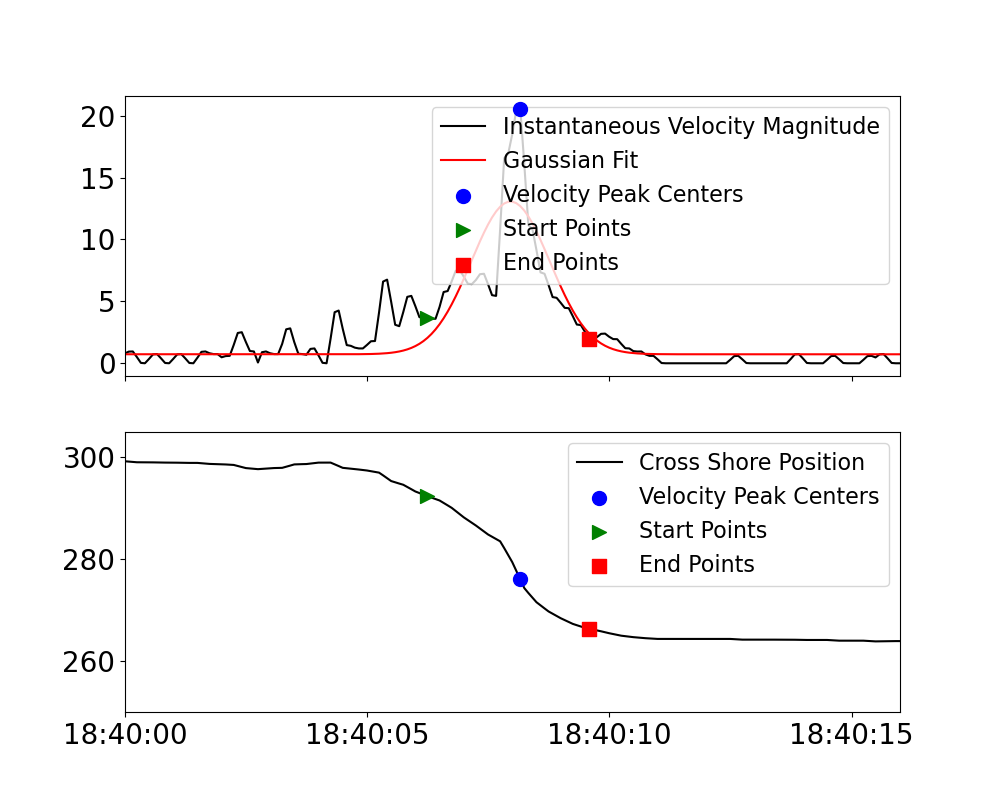

In [49]:
# # Look at the data surrounding the peak index
# # Select the region around the peak
# n = 0
# window = 100
# peak_index = peak_vel_indices[n]
# delta_t = 1/12

# # nans, _ = nan_helper(speed_values_in_window)
# # speed_values_in_window[nans]= np.interp(time_values_in_window[nans], time_values_in_window[~nans], speed_values_in_window[~nans])

# # # Remove the mean value from the speeds
# # # mean_speed_in_jump_window = np.nanmean(speed_values_in_window)
# # mean_speed_in_jump_window = np.nanmean(instantaneous_x_vel)
# # speed_values_in_window_nomean = speed_values_in_window - mean_speed_in_jump_window

# # # Initial guess for the parameters
# # initial_guess = [max(speed_values_in_window), peak_index, 1.0]

# # # Fit the Data in the window to a guassian function
# # popt, _ = curve_fit(gaussian, time_values_in_window, speed_values_in_window_nomean, p0=initial_guess) 
# # amplitude, gaussian_center_index, stddev = popt
# # ten_percent_max_with_offset = ((instantaneous_x_vel[peak_vel_indices[n]] - mean_speed_in_jump_window) * 0.1) + mean_speed_in_jump_window
# # fit_gaussian = (gaussian(time_values_in_window, amplitude, gaussian_center_index, stddev) + mean_speed_in_jump_window)
# # width = np.abs(4.3 * stddev) # This is the "Full Width at Tenth of Maximum" (FWTM) value for a gaussian in indices
# # start_point = int(int(gaussian_center_index) - width//2)
# # end_point = int(int(gaussian_center_index) + width//2)

# Plot the window of data and the optimized guassian
fig, (ax1, ax2) = plt.subplots(figsize=(10,8), nrows=2, sharex=True)
ax1.plot(time[peak_vel_indices[n] - window : peak_vel_indices[n] + window + 1], speed_values_in_window, color='k', label='Instantaneous Velocity Magnitude')
ax1.plot(time[peak_vel_indices[n] - window : peak_vel_indices[n] + window + 1], fit_gaussian, color='r', label='Gaussian Fit')
ax1.scatter(time[peak_vel_indices[n]], instantaneous_total_vel_nofilter[peak_vel_indices[n]], color='b', s=100, label='Velocity Peak Centers', zorder=10)
ax1.scatter(time[start_point], instantaneous_total_vel_nofilter[start_point], color='g', marker='>', s=100, label='Start Points', zorder=10)
ax1.scatter(time[end_point], instantaneous_total_vel_nofilter[end_point], color='r', marker='s', s=100, label='End Points', zorder=10)
# ax1.axhline(ten_percent_max_with_offset, color='k', linestyle='dashed', label='Full Width at 10% Maximum')
# ax1.axhline(mean_speed_in_jump_window, color='k', linestyle='dotted', label=f'Mean Drift Speed, {np.round(mean_speed_in_jump_window, 2)} m/s')
ax1.legend(fontsize=16)
# ax1.set_xlabel('Time [seconds]')
# ax1.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax1.tick_params(axis='both', labelsize=20)

# Check the points on the distance curve
ax2.plot(time, x, color='k', label='Cross Shore Position', zorder=0)
ax2.scatter(time[peak_vel_indices], x[peak_vel_indices], color='b', s=100, label='Velocity Peak Centers', zorder=10)
ax2.scatter(time[start_point], x[start_point], color='g', marker='>', s=100, label='Start Points', zorder=10)
ax2.scatter(time[end_point], x[end_point], color='r', marker='s', s=100, label='End Points', zorder=10)
ax2.legend(fontsize=16)
# ax2.set_xlabel('Time [UTC]')
# ax2.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 40, 0), datetime.datetime(2021, 10, 8, 18, 40, 16))
ax2.set_ylim(250, 305)
ax2.tick_params(axis='both', labelsize=20)


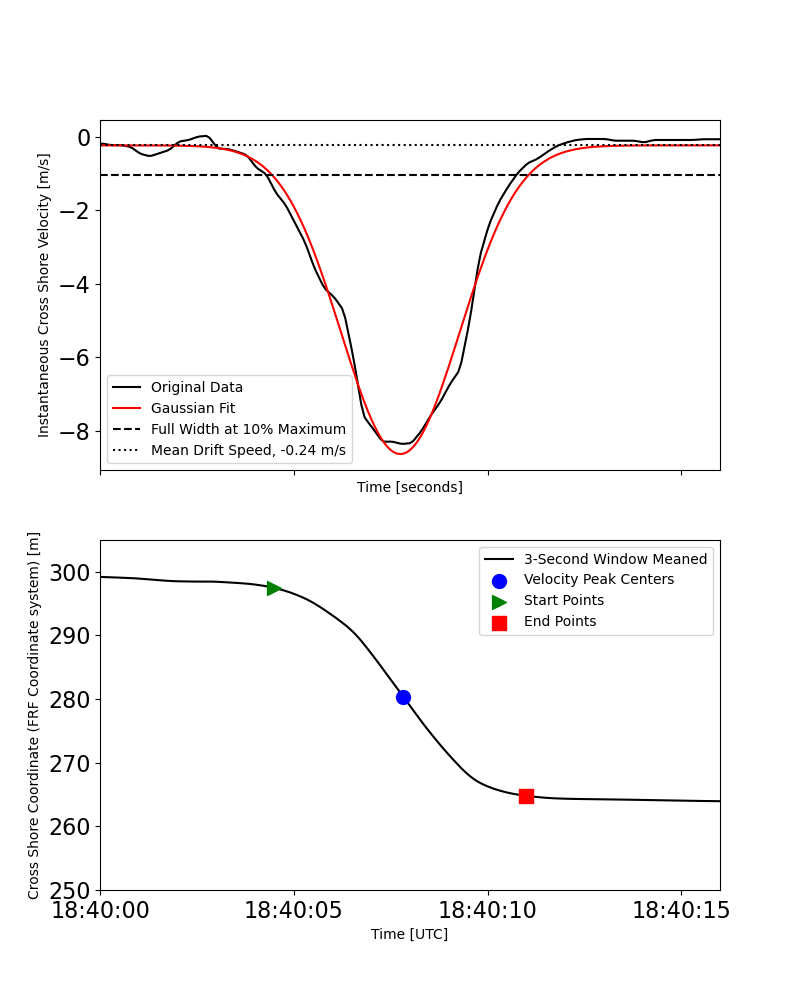

In [7]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

# Look at the data surrounding the peak index
# Select the region around the peak
n = 0
window = 100
peak_index = peak_vel_indices[n]
delta_t = 1/12

time_values_in_window = np.arange(max(0, peak_vel_indices[n] - window), min(instantaneous_x_vel.size, peak_vel_indices[n] + window + 1))
speed_values_in_window = instantaneous_x_vel[max(0, peak_vel_indices[n] - window):min(instantaneous_x_vel.size, peak_vel_indices[n] + window + 1)] 

# Fill NaN Values with linear interpolation to fit for the gaussian
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

nans, _ = nan_helper(speed_values_in_window)
speed_values_in_window[nans]= np.interp(time_values_in_window[nans], time_values_in_window[~nans], speed_values_in_window[~nans])

# Remove the mean value from the speeds
# mean_speed_in_jump_window = np.nanmean(speed_values_in_window)
mean_speed_in_jump_window = np.nanmean(instantaneous_x_vel)
speed_values_in_window_nomean = speed_values_in_window - mean_speed_in_jump_window

# Initial guess for the parameters
initial_guess = [max(speed_values_in_window), peak_index, 1.0]

# Fit the Data in the window to a guassian function
popt, _ = curve_fit(gaussian, time_values_in_window, speed_values_in_window_nomean, p0=initial_guess) 
amplitude, gaussian_center_index, stddev = popt
ten_percent_max_with_offset = ((instantaneous_x_vel[peak_vel_indices[n]] - mean_speed_in_jump_window) * 0.1) + mean_speed_in_jump_window
fit_gaussian = (gaussian(time_values_in_window, amplitude, gaussian_center_index, stddev) + mean_speed_in_jump_window)
width = np.abs(4.3 * stddev) # This is the "Full Width at Tenth of Maximum" (FWTM) value for a gaussian in indices
start_point = int(int(gaussian_center_index) - width//2)
end_point = int(int(gaussian_center_index) + width//2)

# Plot the window of data and the optimized guassian
fig, (ax1, ax2) = plt.subplots(figsize=(8,10), nrows=2, sharex=True)
ax1.plot(time[peak_index - window : peak_index + window + 1], speed_values_in_window, color='k', label='Original Data')
ax1.plot(time[peak_index - window : peak_index + window + 1], fit_gaussian, color='r', label='Gaussian Fit')
ax1.axhline(ten_percent_max_with_offset, color='k', linestyle='dashed', label='Full Width at 10% Maximum')
ax1.axhline(mean_speed_in_jump_window, color='k', linestyle='dotted', label=f'Mean Drift Speed, {np.round(mean_speed_in_jump_window, 2)} m/s')
ax1.legend()
ax1.set_xlabel('Time [seconds]')
ax1.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax1.tick_params(axis='both', labelsize=16)

# Check the points on the distance curve
ax2.plot(time, x_filtered, color='k', label='3-Second Window Meaned', zorder=0)
ax2.scatter(time[peak_vel_indices], x_filtered[peak_vel_indices], color='b', s=100, label='Velocity Peak Centers', zorder=10)
ax2.scatter(time[start_point], x_filtered[start_point], color='g', marker='>', s=100, label='Start Points', zorder=10)
ax2.scatter(time[end_point], x_filtered[end_point], color='r', marker='s', s=100, label='End Points', zorder=10)
ax2.legend()
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 40, 0), datetime.datetime(2021, 10, 8, 18, 40, 16))
ax2.set_ylim(250, 305)
ax2.tick_params(axis='both', labelsize=16)
